In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from assimilation import ExtendedKF, OI, EnKF

In [92]:
def lorenz96_fdm(x0, ts, F=8):
    dt = ts[1] - ts[0]
    x = np.zeros((x0.size, ts.size))
    x[:,0] = x0.ravel()
    
    for idx, time in enumerate(ts[1:]):
        xn = x[:,idx]
        xn_p1 = np.roll(xn, -1)  # x_{n+1}
        xn_m1 = np.roll(xn, 1)  # x_{n-1}
        xn_m2 = np.roll(xn, 2)  # x_{n-2}
        x[:,idx+1] = xn + dt * ((xn_p1-xn_m2) * xn_m1 - xn + F)
        
    return x

def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err

In [8]:
seed = 42
rng = np.random.RandomState(seed)

N = 40  # number of variables
X_ini = rng.randint(0, 10, size=N)

F = 8
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X_nature = lorenz96_fdm(X_ini, ts, F)
X_nature.shape

(40, 1600)

In [32]:
X_ini = X_nature[:,[40]] + np.random.randn(40, 1)

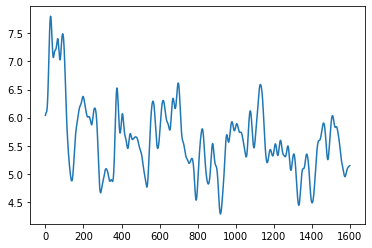

In [36]:
ts = np.arange(0, time, dt)
X_forecast = lorenz96_fdm(X_ini, ts)
rmse = np.sqrt(np.mean((X_forecast-X_nature)**2, axis=0))

plt.plot(rmse);

### OI

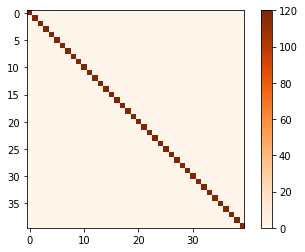

In [167]:
obs_var = 100
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = R * 1.2
Pb += np.diag(1*np.ones(N-1), k=1) + np.diag(1*np.ones(N-1), k=-1)
Pb += np.diag(0.5*np.ones(N-2), k=2) + np.diag(0.5*np.ones(N-2), k=-2)
Pb += np.diag(0.25*np.ones(N-3), k=3) + np.diag(0.25*np.ones(N-3), k=-3)

plt.imshow(Pb, cmap='Oranges', interpolation='nearest')
plt.colorbar();

In [168]:
oi = OI(lorenz96_fdm, dt)
oi.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(40)
}
oi.set_params(**params)
oi.cycle()

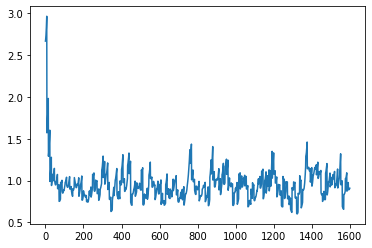

In [169]:
rmse_oi = np.sqrt(np.mean((oi.analysis-X_nature)**2, axis=0))
plt.plot(rmse_oi);

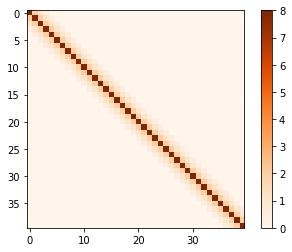

In [141]:
R = np.eye(40) * 2
Pb = R * 4
Pb += np.diag(2*np.ones(N-1), k=1) + np.diag(2*np.ones(N-1), k=-1)
Pb += np.diag(1*np.ones(N-2), k=2) + np.diag(1*np.ones(N-2), k=-2)
Pb += np.diag(0.5*np.ones(N-3), k=3) + np.diag(0.5*np.ones(N-3), k=-3)

min_eig = np.min(np.real(np.linalg.eigvals(Pb)))
if min_eig < 0:
    Pb -= 10*min_eig * np.eye(*Pb.shape)

plt.imshow(Pb, cmap='Oranges', interpolation='nearest')
plt.colorbar();

In [142]:
obs_var = 2
obs_timeintv = 0.08
obs_intv = 8
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((40, size))
for irow in range(40):
    X_obs_err[irow,:] = gen_random_obserr(0, obs_var, size, obs_intv)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]
X_obs.shape

(40, 200)

### EnKF

In [143]:
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (40, N_ens)
X_ens_ini += 3 + 2 * np.random.randn(40, 1)
#X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (40, N_ens)

enkf = EnKF(lorenz96_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf.set_params(**params)
enkf.cycle()

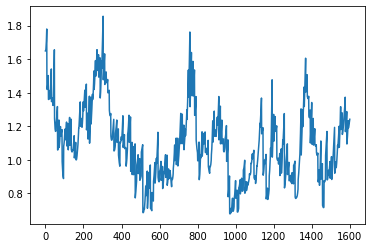

In [144]:
ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
plt.plot(rmse_enkf);

In [121]:
inflats = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for inflat in inflats:
    for alpha in alphas:
        enkf = EnKF(lorenz96_fdm, dt)
        enkf.list_params()
        params = {
            'X_ens_ini': X_ens_ini,
            'obs': X_obs,
            'obs_interv': 8,
            'R': R,
            'H_func': lambda arr: arr,
            'alpha': 0.4,
            'inflat': 1.5
        }
        enkf.set_params(**params)
        enkf.cycle()

        ens_mean = enkf.analysis.mean(axis=0)
        rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
        print(inflat, alpha, rmse_enkf.mean())

1 0 0.9257911632580722
1 0.1 1.031273990041626
1 0.2 0.9664808637349941
1 0.3 1.066779082306364
1 0.4 1.0000994026591947
1 0.5 1.2105093832162026
1 0.6 1.0185737225438138
1 0.7 0.9714133015447436
1 0.8 0.9815591911925577
1.1 0 1.0241183753878007
1.1 0.1 1.3140252431001165
1.1 0.2 0.9829518937708386
1.1 0.3 1.0757430976640752
1.1 0.4 1.1197172867393264
1.1 0.5 1.2465842613652638
1.1 0.6 0.950616545439582
1.1 0.7 1.0581260638395276
1.1 0.8 1.0849187388088408
1.2 0 0.9789816540480595
1.2 0.1 1.023131841466013
1.2 0.2 1.0485804229717217
1.2 0.3 0.9905165487217752
1.2 0.4 1.130779343067622
1.2 0.5 0.942423236743406
1.2 0.6 0.987168334853033
1.2 0.7 1.0895186831265742
1.2 0.8 0.9764137747785342
1.3 0 1.01000618252946
1.3 0.1 1.0505534959414875
1.3 0.2 0.9587683509891537
1.3 0.3 1.1408645411509182
1.3 0.4 1.1336632247601
1.3 0.5 1.1257819540849996
1.3 0.6 0.9789743434786317
1.3 0.7 1.0573159382947122
1.3 0.8 1.0330778624294006
1.4 0 1.0662371732986258
1.4 0.1 1.0858724586804374
1.4 0.2 0.8956